<span style="font-family:Papyrus; font-size:3em;">Lecture 16: Testing Model Dynamics</span>

This chapter discusses testing the dynamics of kinetic models.
The final section applies these techniques to the running example of glycolytic oscillations.

# Preliminaries

In [26]:
IS_COLAB = False
#
if IS_COLAB:
    !pip install matplotlib
    !pip install numpy
    !pip install tellurium
    !pip install SBMLLint
    !pip install SBstoat
#    
# Constants for standalone notebook
if not IS_COLAB:
    CODE_DIR = "/home/ubuntu/advancing-biomedical-models/common"
    MODEL_DIR = "/home/ubuntu/advancing-biomedical-models/labs/models"
else:
    from google.colab import drive
    drive.mount('/content/drive')
    CODE_DIR = "/content/drive/MyDrive/Winter 2021/common"
    MODEL_DIR = "/content/drive/MyDrive/Winter 2021/Labs/models"
import sys
sys.path.insert(0, CODE_DIR)

In [2]:
# Python packages used in this section
import os
import matplotlib.pyplot as plt
import numpy as np
import util
import util_doe1
import tellurium as te

In [3]:
# Constants
ENDTIME = 10
NUMPOINT = 10*ENDTIME

# Motivating Example
We begin with a motivating example.
Consider a linear pathway consisting of three species ``S1``, ``S2``, and ``S3``. That is, ``S1`` $\rightarrow$ ``S2`` $\rightarrow$ ``S3``.

We initialize ``S1`` to 10. We expect that the following outcomes (designated by **On**):

- **O1**: ``S1`` decreases monotonically from 10 to 0.
- **O2**: ``S2`` increases initially, peaks, and then declises to 0.
- **O3**: ``S3`` increases monotonically to 10. 

Here is a first implementation of the model.

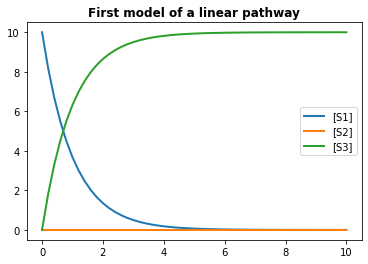

In [4]:
FIRST_IMPLEMENTATION = '''
R1: S1 -> S2; k1*S1  
R2: S2 -> S3; k2*S1

S1 = 10
k1 = 1; k2 = 1
'''
rr = te.loada(FIRST_IMPLEMENTATION)
data = rr.simulate(0, ENDTIME)
rr.plot(data, title="First model of a linear pathway")

We see that O1 and O3 are satisfied. However, O2 is not. Why?

Looking carefully at the Antimony model, we see there is an error in the specification of the kinetics law for reaction ``R2``. The kinetics law incorrectly references ``S1`` instead of ``S2``. Below is the corrected model.

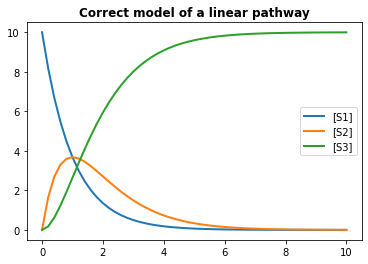

In [5]:
CORRECT_MODEL = '''
R1:  S1 -> S2; k1*S1  
R2a: S2 -> S3; k2*S2

S1 = 10
k1 = 1; k2 = 1;
'''
rr = te.loada(CORRECT_MODEL)
data = rr.simulate(0, ENDTIME)
rr.plot(data, title="Correct model of a linear pathway")

In this model, all three outcomes are satisfied.

Although the example is simple, it demonstrates how easy it is to make mistakes in the construction of models, especially complex models. A few mistakes can be detected by tellurium, such as misspelling the name of a floating species. However, the mistake made in the first model, substituting ``S1`` for ``S2``, is not detected by Tellurium.

How do we detect errors in the implementation of models (a processing often referred to as *verification*)? By implementation of the model, we mean that there is a clear understanding of the expected behavior of the model. Verification is about providing ways to detect if the implemention provides the expected behavior.

Although our focus here is on verification, making sure that the intended model is what was built, there is another challenge in modeling. That is, choosing the corrrect model to implement.
Modellers address this by checking for correspondence between simulation data and laboratory measurements.
This process is called **validation**.
Both verification and validation are essential to producing useful models.
However, it makes no sense to validate a model that is implemented incorrectly.
Further, while there is considerable focus in the literature on model validation, there is almost no discussion of verification.

This chaper is about verifying simulation models, or verification testing.
Such testing is done by examining models and their outputs.
There are two kinds of verification tests.

The first kind of verification tests only examines the model itself; the model is not executed.
We refer to these as **static tests**.
For example, one static test is to look for suspicious kinetics laws, such as the kinetics law for ``R2``
that references a floating species that is neither a reactant nor a product (which would be incorrect
if the intended kinetics are mass action).
In the above example, 
Drawing on the experience of the software industry over the last 50 years,
we identify two kinds of validation.

The second kind of verification tests runs simulations and compares the results with what the model developer
expected.
This is illustrated by outcomes O1-O3 and our analysis of the above two simulation models.

# Expected Outcomes

Dynamic testing is about verifying the output produced by a simulation.

This is illustrated at the beginning of the chapter using the example
of a linear pathway consisting of three species ``S1``, ``S2``, and ``S3``. That is, ``S1`` $\rightarrow$ ``S2`` $\rightarrow$ ``S3``, with ``S1`` initialized to 10. 

We showed that the following outcomes were expected from the simulation:

- **O1**: ``S1`` decreases monotonically from 10 to 0.
- **O2**: ``S2`` increases initially, peaks, and then declises to 0.
- **O3**: ``S3`` increases monotonically to 10. 


The expected outcomes are the starting point for constructing verification tests.
Implementing these tests requires two Boolean helper functions.
A Boolean function returns either ``True`` or ``False``.
The first helper function, ``isMonotone``, takes as input a list or array of values and
the direction expected (+1 for monotone increasing and -1 for monotone decreasing).
The function returns ``True`` if the data are monotone in the desired direction.

In [6]:
def expectMonotone(values, isIncreasing=True):
    """
    Checks that the values is monotone in the desired direction.
    
    Parameters
    ----------
    values: list-float
    isIncreasing: bool
    
    Returns
    -------
    bool
    """
    if isIncreasing:
        direction = 1
    else:
        direction = -1
    arr = np.array(values)
    diff = direction*(arr[1:] - arr[:-1])
    return all([v > 0 for v in diff])

# Tests
assert(expectMonotone([1, 2, 3]))
assert(expectMonotone([3, 2, 1], isIncreasing=False))
assert(not expectMonotone([1, 2, 3, 2, 1]))

``isMonotone`` allows us to check the conditions O1 and O3. For O2, we need to check that the values initially increase,
and then decrease. Curves with this shape are called *concave*. That is, there is some intermediate point at which the series changes from increasing to
decreasing. 

In [7]:
def expectConcave(values):
    """
    Checks that the data have a concave shape; that is,
    they increase to a maximum and the optionally, decrease.
    
    Parameters
    ----------
    values: list-float
    """
    arr = np.array(values)
    result = False
    for idx in range(1, len(values)-2):
        isIncreasing = expectMonotone(arr[:idx], isIncreasing=True)
        isDecreasing = expectMonotone(arr[idx:], isIncreasing=False)
        if isIncreasing and isDecreasing:
            result = True
            break
    if not result:
        result = expectMonotone(values, isIncreasing=True)
    return result

# Tests
assert(expectConcave([0, 1, 2, 3]))
assert(expectConcave([0, 1, 2, 3, 2, 1]))
assert(not expectConcave([3, 2, 1]))

We illustrate these functions below.

In [8]:
# Illustration of isMonotone, isConcave
for values in [ [1, 2, 3, 4], [4, 3, 2, 1], [1, 4, 3, 2]]:
    print("\nAnalyzing the series: %s" % str(values))
    print("  Increasing? %s" % str(expectMonotone(values, isIncreasing=True)))
    print("  Decreasing? %s" % str(expectMonotone(values, isIncreasing=False)))
    print("  Concave? %s" % str(expectConcave(values)))


Analyzing the series: [1, 2, 3, 4]
  Increasing? True
  Decreasing? False
  Concave? True

Analyzing the series: [4, 3, 2, 1]
  Increasing? False
  Decreasing? True
  Concave? True

Analyzing the series: [1, 4, 3, 2]
  Increasing? False
  Decreasing? False
  Concave? True


# Test Infrastructure

Now that we have a way to test the outcomes, we need to write codes that use these tests.
Fortunately, python provides a convenient way to do this with its ``unittest`` infrastructure.
Using the infrastructure requires the following:
- Copy the test template. The template consists of:
  - ``import unittest``
  - ``class TestModel(unittest.TestCase)``
- Write a setUp function within ``TestModel`` that loads the model and gets simulation data.
- Write tests that check the appropriate values in the simulation output.

This is done below for the linear pathway.
Note that the code expects that the variable ``MODEL`` is the antimony codes for the model being tested. We see that there
is a separate test for each column.

In [9]:
import unittest

# Performs unittests on MODEL

# Define a class in which the tests will run
class TestModel(unittest.TestCase):
    
    def setUp(self):
        self.roadrunner = te.loada(MODEL)
        self.data = self.roadrunner.simulate(0, ENDTIME, NUMPOINT)
        
    def testS1(self):
        self.assertTrue(expectMonotone(self.data["[S1]"], isIncreasing=False))
          
    def testS2(self):
        self.assertTrue(expectConcave(self.data["[S2]"]))
                
    def testS3(self):
        self.assertTrue(expectMonotone(self.data["[S3]"], isIncreasing=True))

To run the model, you assign ``MODEL`` and then run the two lines that follow this assignment.

In [10]:
MODEL = CORRECT_MODEL
suite = unittest.TestLoader().loadTestsFromTestCase(TestModel)
_ = unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 0.017s

OK


These codes ran the 3 tests. All three passed for ``CORRECT_MODEL``. Now consider what happens with the model in ``FIRST_IMPLEMENTATION`` that fails on the test for ``S2``.

In [11]:
MODEL = FIRST_IMPLEMENTATION
suite = unittest.TestLoader().loadTestsFromTestCase(TestModel)
_ = unittest.TextTestRunner().run(suite)

.F.
FAIL: testS2 (__main__.TestModel)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-9-cc1a7020f82b>", line 16, in testS2
    self.assertTrue(expectConcave(self.data["[S2]"]))
AssertionError: False is not true

----------------------------------------------------------------------
Ran 3 tests in 0.101s

FAILED (failures=1)


We have demonstrated these tests in the Jupyter notebook. However, in practice, the tests would be in
a separate python modeule (a file ending in ``.py``). Ideally, these test files are run whenever there is a
change to the model or its supporting code.
Systems such as ``github`` provide a way to run these tests automatically whenever the model changes, a process referred to
as *continuous integration*.

# Application to Glycolytic Oscillations
This section applies the idea of model testing to our running example of glycolytic oscillations.
We begin by introduce several constants.
Constants are in all capital letters; they are assigned once, and their values do not change.

## Wolf Model

In [12]:
# Constants used in the section
WOLF_MODEL = "../common/Jana_WolfGlycolysis.antimony"
MOLECULES = ["Glucose", "fructose_1_6_bisphosphate", "glyceraldehyde_3_phosphate", "glycerate_3_phosphate",
            "pyruvate", "Acetyladehyde", "External_acetaldehyde", "ATP", "ADP", "NAD", "NADH"]
ENDTIME = 5
NUMPOINT = 100*ENDTIME
ROADRUNNER = te.loada(WOLF_MODEL)

In this section, we consider tests to verify the simulation of glycolytic oscillations used in our running example. The use case considered is one in which a team plans to modify the original model.
This may involve both the addition and removal of reactions.

Recall that the reactions in this model are:

  ``
  J0: $External_glucose => Glucose; J0_inputFlux;
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glyceraldehyde_3_phosphate*NADH;
  J4: glyceraldehyde_3_phosphate + ADP + NAD => ATP + glycerate_3_phosphate + NADH; (J4_kg*J4_kp*glyceraldehyde_3_phosphate*NAD*ADP - J4_ka*J4_kk*glycerate_3_phosphate*ATP*NADH)/(J4_ka*NADH + J4_kp*ADP);
  J5: glycerate_3_phosphate + ADP => ATP + pyruvate; J5_k*glycerate_3_phosphate*ADP;
  J6: pyruvate => Acetyladehyde; J6_k*pyruvate;
  J7: Acetyladehyde + NADH => NAD + $ethanol; J7_k*Acetyladehyde*NADH;
  J8: Acetyladehyde => External_acetaldehyde; J8_k1*Acetyladehyde - J8_k2*External_acetaldehyde;
  J9: ATP => ADP; J9_k*ATP;
  J10: External_acetaldehyde => $Sink; J10_k*External_acetaldehyde;``

## What tests?

The use case for dynamic tests is that a baseline model, in this case the Wolf model, is being
modified. The specific modifications considered here are changes in parameter values.
We want dynamic tests that ensure that essential characteristics of the model are preserved
when parameter values are changed.

What are these essential characteristics? Answering this question requires looking at the data produced
by the baseline model.

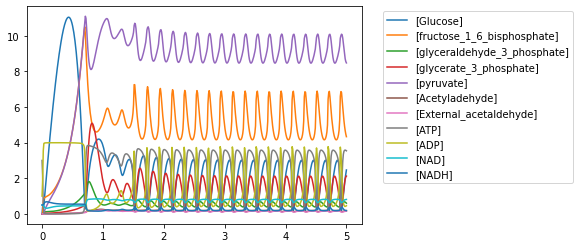

In [13]:
# Floating species concentrations over time
DATA = ROADRUNNER.simulate(0, ENDTIME, NUMPOINT)
def timePlots(data=DATA):
    p = plt.plot(data[:,0], data[:,1:])
    _ = plt.legend(p, data.colnames[1:], bbox_to_anchor=(1.05, 1), loc='upper left')
timePlots()

We see that there is an initial transient. But starting at time 1.5 sec to 2 sec, concentrations oscillate. We'll focus on these oscillations in our tests of the model.

One way to characterize oscillations is by using the fourier transform. Below, we introduce the function ``getFft`` that calculates the fast fourier transform
(FFT) for a chemical species, and a second function, ``plotFft``, that plots the FFT.

In [14]:
def plotFft(molecule, data=DATA, ax=None, isPlot=True):
    """
    Plots the FFt for a molecule
    
    Parameters
    ----------
    molecule: str
    data: NamedArray
    ax: Matplotlib.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(1,1)
    else:
        fig = None
    freqs, fftValues = util_doe1.calculateFft(molecule, data=data)
    ax.plot(freqs, fftValues)
    ax.set_title(molecule)
    ax.set_ylim([0, 130])
    if not isPlot:
        if fig is not None:
            fig.clear()
            
# Tests
plotFft("Glucose", isPlot=False)  # Smoke test

<Figure size 432x288 with 0 Axes>

Using these functions, we construct plots for all of the chemical species in the output.

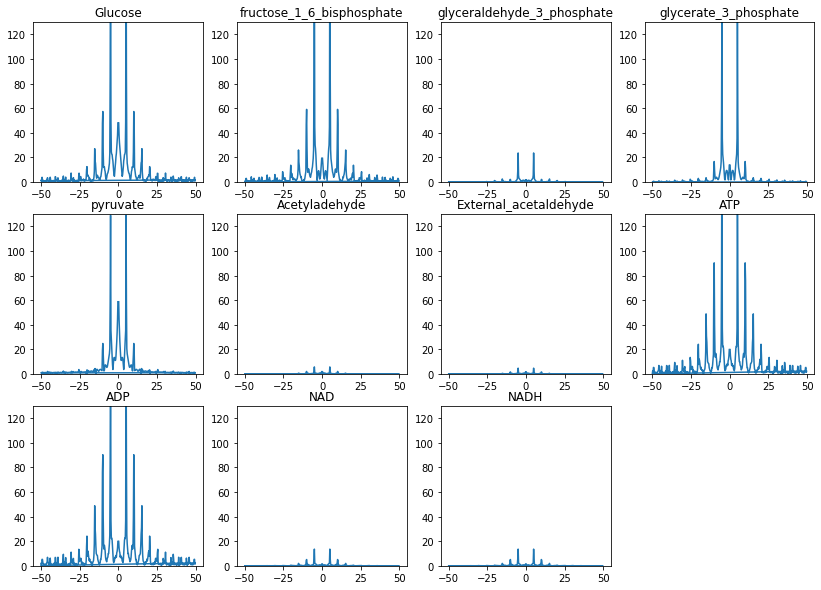

In [15]:
# Construct a plot of the amplitude of the fourier transforms of all floating species.
numCol = 4
numRow = 3
fig = plt.figure(figsize=(14,10))
for irow in range(numRow):
    for icol in range(numCol):
        idx = irow*numCol + icol
        if idx >= len(MOLECULES):
            break
        ax = plt.subplot2grid((numRow, numCol), (irow, icol), fig=fig)
        plotFft(MOLECULES[idx], ax=ax)

The above plots use the same scale for the vertical axis ($y$). It seems that all chemical species indicate strong perodicities at a frequency of 5 Hz (5 cycles per second), with harmonics at multiples of this frequency.

Given this, a natural test for the baseline model is that all chemical species show a 5 Hz perodicity. We can check for this using the following codes.

In [16]:
def expectFrequency(molecule, data=DATA, frequency=5.0, topN=2):
    """
    Checks if the frequenc for the molecule is in the top amplitudes (Fourier coefficient)
    
    Parameters
    ----------
    molecule: str
    data: NamedArray
    frequency: float
    topN: int
    
    Returns
    -------
    bool
    """
    # Return True if the expected frequency is among the topN frequencies with the largest amplitudes
    freqs, amplitudes = util_doe1.calculateFft(molecule, data=data)
    # Find the indices of the largest amplitudes
    sortedIndices = sorted(range(len(freqs)), key=lambda i: amplitudes[i], reverse=True)
    # See if the frequency is in the frequencies
    return frequency in list(freqs[sortedIndices[:topN]])

# Tests
assert(expectFrequency("Glucose", frequency=5.0))
assert(not expectFrequency("Glucose", frequency=6.0, topN=20))

## Tests

Now we show how to create a test that can be run on a roadrunner model. We do this making use of the python ``unittest`` infrastructure, as described in previously in this chapter.
For each chemical species considered, we will have two tests.
One test checks that there is a frequency of 5 Hz; the second checks
that there is no frequency of 7 Hz.

In our use case, we consider the model evolving by making modifications to parameter values.
Changes in parameter values are in the python variable ``PARAMETER_DCT``, a python dictionary;
the key is the parameter name, and the value is its new value.
The following provide access to updating parameter values.

Below are the unittests that use ``PARAMETER_DCT`` to modify ``WOLF_MODEL``.

In [17]:
import unittest

# Define a class in which the tests will run
class TestModel(unittest.TestCase):
    
    def setUp(self):
        self.roadrunner = updateParameters(PARAMETER_DCT)
        self.roadrunner.reset()
        self.data = self.roadrunner.simulate(0, ENDTIME, NUMPOINT)
        
    def testGlucoseHasFrequency(self):
        self.assertTrue(expectFrequency("Glucose", data=self.data, frequency=5.0))    
            
    def testGlucoseDoesNotHaveFrequency(self):
        self.assertFalse(expectFrequency("Glucose", data=self.data, frequency=7.0))   
            
    def testNADHHasFrequency(self):
        self.assertTrue(expectFrequency("NADH", data=self.data, frequency=5.0))    
            
    def testNADHDoesNotHaveFrequency(self):
        self.assertFalse(expectFrequency("NADH", data=self.data, frequency=7.0))

The function ``updateParameters`` creates a model with whose parameter values are changed to those specified in
a dictionary. The key of the dictionary is the SBML ID of the parameter; the value is the new value for the parameter.

In [18]:
# Returns a roadrunner model with the desired parameter values
def updateParameters(parameterDct):
    """
    Creates an updated roadrunner model with the specified parameters.
    
    Parameters
    ----------
    parameterDct: dict
        key: parameter name
        value: new value
        
    Returns
    -------
    ExtendedRoadrunner
    """
    rr = te.loada(WOLF_MODEL)
    for name, value in parameterDct.items():
        rr[name] = value
    return rr

# Tests
assert(isinstance(updateParameters({}), te.roadrunner.ExtendedRoadRunner))

Now, we begin our exploration of parameter values. First, we check that all tests pass if there is no change in parameter value.

In [19]:
# Run the tests without changing the model
def runTests(parameterDct, isPlot=True):
    """
    Plots Glucose and NADH and runs tests.
    
    Parameters
    ----------
    parameterDct: dict
    """
    global PARAMETER_DCT
    rr = updateParameters(parameterDct)
    rr.reset()
    data = rr.simulate(0, ENDTIME, NUMPOINT)
    xv = data["time"]
    y1v = data["[Glucose]"]
    y2v = data["[NADH]"]
    fig, ax = plt.subplots(1)
    ax.plot(xv, y1v, xv, y2v)
    plt.legend(["Glucose", "NADH"])
    if not isPlot:
        fig.clear()
    PARAMETER_DCT = parameterDct
    suite = unittest.TestLoader().loadTestsFromTestCase(TestModel)
    _ = unittest.TextTestRunner().run(suite)
    
# Tests
runTests({}, isPlot=False)

....
----------------------------------------------------------------------
Ran 4 tests in 0.105s

OK


<Figure size 432x288 with 0 Axes>

Next, we consider a small change in the the parameter ``J1_k1`` in the reaction
``J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP`` with the kinetics law ``J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n))``. We change this parameter from its baseline value of 550 to 530.

....
----------------------------------------------------------------------
Ran 4 tests in 0.105s

OK


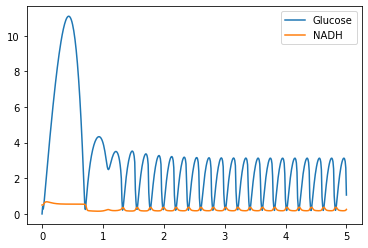

In [20]:
# Run tests with changing J1_k1 from 550 to 530.
runTests({"J1_k1": 530})

This reduction in ``J1_k1`` preserves the frequency characteristics of the chemical species. So, we consider a further reduction in the value of the parameter.

.F.F
FAIL: testGlucoseHasFrequency (__main__.TestModel)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-17-623735298d52>", line 12, in testGlucoseHasFrequency
    self.assertTrue(expectFrequency("Glucose", data=self.data, frequency=5.0))
AssertionError: False is not true

FAIL: testNADHHasFrequency (__main__.TestModel)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-17-623735298d52>", line 18, in testNADHHasFrequency
    self.assertTrue(expectFrequency("NADH", data=self.data, frequency=5.0))
AssertionError: False is not true

----------------------------------------------------------------------
Ran 4 tests in 0.101s

FAILED (failures=2)


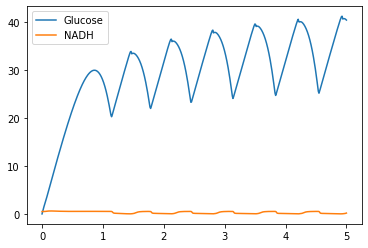

In [21]:
# Run tests with changing J1_k1 from 550 to 500.
runTests({"J1_k1": 10})

This time the test fails.

# Exercise

Develop a test for BioModels 851.

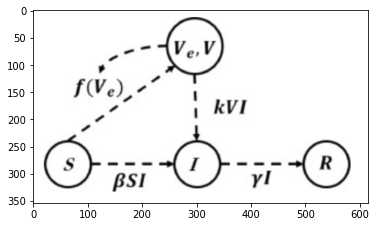

In [22]:
pngPath = os.path.join(MODEL_DIR, "model851.png")
util.showImage(pngPath)

In [23]:
model851Str, rr851 = util.getModel(851)
print(model851Str)

// Created by libAntimony v2.12.0
function Function_for_Susceptible_Individual_Transmission(beta, I, S)
  beta*I*S;
end

Function_for_Susceptible_Individual_Transmission is "Function_for_Susceptible_Individual_Transmission"

function Function_for_Vaccinated_Population_Growth(r, V_e, A)
  r*(1 - V_e/A);
end

Function_for_Vaccinated_Population_Growth is "Function_for_Vaccinated_Population_Growth"

function Function_for_Vaccinated_Population_Infection(k, I, V)
  k*I*V;
end

Function_for_Vaccinated_Population_Infection is "Function_for_Vaccinated_Population_Infection"


model *Ho2019___Mathematical_models_of_transmission_dynamics_and_vaccine_strategies_in_Hong_Kong_during_the_2017_2018_winter_influenza_season__Simple()

  // Compartments and Species:
  compartment compartment_;
  species S in compartment_, V in compartment_, V_e in compartment_, I in compartment_;
  species R in compartment_;

  // Assignment Rules:
  k := ModelValue_3*(1 - ModelValue_5);
  fraction_S := S/fraction_total;


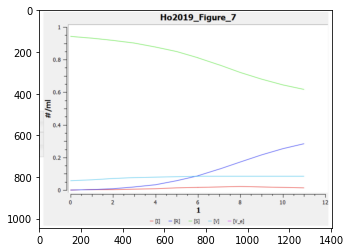

In [24]:
path = os.path.join(MODEL_DIR, "model851_curation.png")
util.showImage(path)

**Question**
1. Write tests for this curation figure. You may need to write additional ``expect`` function.